# Motivation 
in this notebook, we will show how to use the PSD alteration method to generate virtual anomalies.


In [1]:
# set the font size of the figure
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [2]:
# database_path load from config file
from config import settings
from pathlib import Path
settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/settings_simu.lower()).with_suffix('.db')

In [3]:
import sqlite3
import numpy as np
conn = sqlite3.connect(database_path)
c = conn.cursor()
c.execute("SELECT * FROM metadata")
metadata = c.fetchone()
fs, nperseg, filter_order, lpf, freq, SNR = metadata
freq_axis = np.frombuffer(freq, dtype=np.float64)


In [4]:
len(freq_axis)

513

In [5]:
from psm.models.prepare_data import CreateTransformer
cr=CreateTransformer(database_path,freq_axis , 0, 150)
transform_psd = cr.transform_psd
label_transform = cr.transform_label


In [6]:
# load the data using the PSDDataset class 
from psm.models.prepare_data import PSDDataset

# load the data using the PSDDataset class
dataset = PSDDataset(
    database_path=database_path,
    anomaly_level=0,
    stage='test')



(anomaly_level=?) AND stage=? (0, 'test')


In [21]:
import torch
def construct_nodge(freq,f_oi,length,amp):
    freq_index = len(freq)/freq[-1]
    length = np.round(length*freq_index,0).astype('int')
    window  = np.ones(freq.shape)
    hann_len = np.sum(np.abs(freq-f_oi)<length)
    hann = 1-np.hanning(hann_len)*amp
    window[np.abs(freq-f_oi)<length] = hann
    return window

def multiply_signals_log(psd,window):
    log_psd = torch.log(psd)
    #  normalize the psd
    min_psd = torch.min(log_psd)
    max_psd = torch.max(log_psd)
    log_psd = (log_psd - min_psd) / (max_psd - min_psd)
    psd_aff =log_psd+(1-window)
    # then unnormalize the psd
    psd_aff = psd_aff * (max_psd - min_psd) + min_psd
    res = torch.exp(psd_aff)
    return res

def affect_psd(psd,freq,amp,f_oi,length):
    window = construct_nodge(freq=freq,f_oi=f_oi,length=length,amp=amp)
    psd_res = multiply_signals_log(psd,window)
    return psd_res

In [26]:
index_freq = np.argmin(np.abs(freq_int - anomaly_freq))
index_freq

90

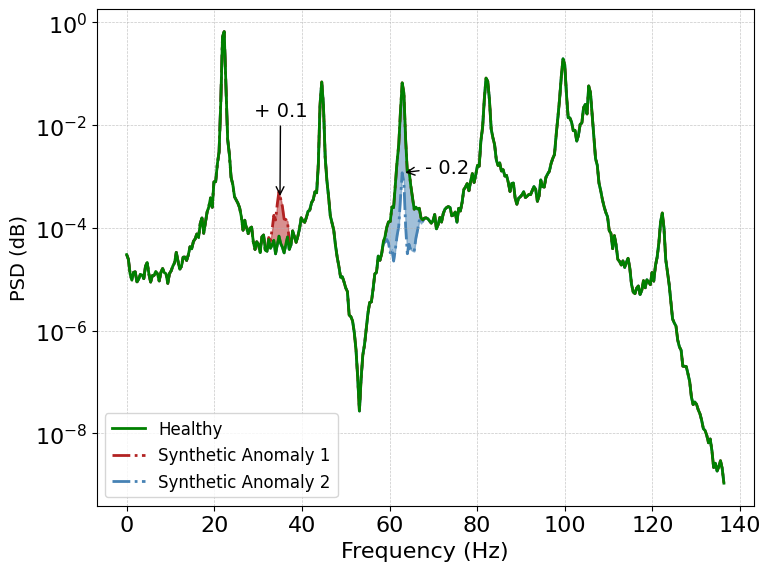

In [50]:
# grab a sample from the dataset
import matplotlib.pyplot as plt

sample = dataset[0][0][0:350]
freq_int = freq_axis[0:350]
sample_aff = affect_psd(sample, freq_int, 0.1, 35, 1)
sample_aff_2 = affect_psd(sample, freq_int, -0.2, 63, 2)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot data
ax.plot(freq_int, sample, label='Healthy', color='green', linewidth=2, zorder=3)
ax.plot(freq_int, sample_aff, linestyle='-.', label='Synthetic Anomaly 1', color='firebrick', linewidth=2, zorder=2)
ax.plot(freq_int, sample_aff_2, linestyle='-.', label='Synthetic Anomaly 2', color='steelblue', linewidth=2, zorder=1)

# Optional: Fill between curves
ax.fill_between(freq_int, sample,sample_aff, color='firebrick', alpha=0.5)
ax.fill_between(freq_int, sample, sample_aff_2, color='steelblue', alpha=0.5)

# Add an arrow annotation
anomaly_freq = 35  # Adjust this value to the frequency where your anomaly occurs
anomaly_loc = sample_aff[np.argmin(np.abs(freq_int - anomaly_freq))]  # Amplitude at anomaly frequency
ax.annotate('+ 0.1', 
            xy=(anomaly_freq, anomaly_loc), 
            xytext=(anomaly_freq-6 , anomaly_loc * 40), 
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=14)
# add another arrow annotation
anomaly_freq = 63  
anomaly_loc = sample_aff_2[np.argmin(np.abs(freq_int - anomaly_freq))]
ax.annotate('- 0.2',
            xy=(anomaly_freq, anomaly_loc),
            xytext=(anomaly_freq+5 , anomaly_loc ),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=14)

# Enhance the grid, title, and labels
ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)', fontsize=14)
ax.tick_params(axis='both', which='major')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('fig/PSD_alteration.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
fs

400.0

In [10]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Define your application
app = dash.Dash(__name__)

# Your actual construct_nodge function and freq_axis, sample arrays go here

app.layout = html.Div([
    dcc.Graph(id='graph'),
    dcc.Slider(
        id='f_oi-slider',
        min=0,
        max=200,
        step=2,
        value=50,
        marks={},
        updatemode='drag'
    ),
    dcc.Slider(
        id='length-slider',
        min=0,
        max=10,
        step=1,
        value=1,
    ),
    dcc.Slider(
        id='amp_slider',
        min=-1,
        max=1,
        step=0.05,
        value=0.5,
    )
])

@app.callback(
    Output('graph', 'figure'),
    [Input('f_oi-slider', 'value'),
     Input('length-slider', 'value'),
     Input('amp_slider', 'value')]
)
def update_graph(f_oi, length, amp):
    anomaly_param = {'f_oi' : f_oi, 'length' : length, 'amp' : amp}
    window = construct_nodge(freq_axis,**anomaly_param)
    psd_res = affect_psd(psd,freq_axis,**anomaly_param)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=freq_axis, y=window, mode='lines', name='notch filter', yaxis='y2'))
    fig.add_trace(go.Scatter(x=freq_axis, y=sample[0], mode='lines', name='original'))
    fig.add_trace(go.Scatter(x=freq_axis, y=psd_res, mode='lines', name='affected'))

    fig.update_layout(
        yaxis_type="log",
        yaxis2=dict(
            title="notch filter",
            titlefont=dict(
                color="red"
            ),
            tickfont=dict(
                color="red"
            ),
            overlaying="y",
            side="right",
            range=[0, 2]
        )
    )
    
    return fig


app.run_server(debug=True)


/tmp/ipykernel_148671/3922309854.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/tmp/ipykernel_148671/3922309854.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


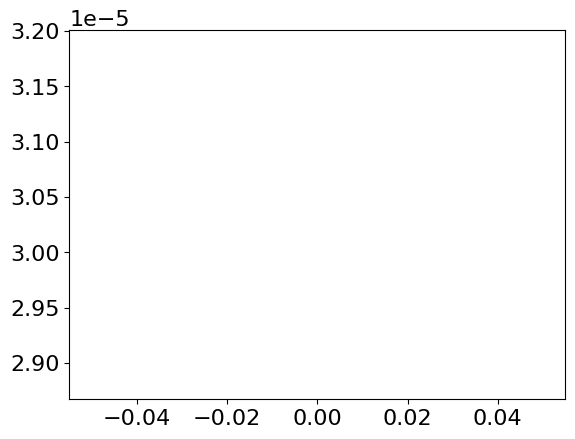

In [11]:
# make a simple plot of the sample 
import matplotlib.pyplot as plt
plt.plot(sample[0])
